<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/ResNet18_Adam_60epochs_lr%3D0_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [6]:
data_dir = '/content/drive/Shareddrives/8:1:1_shortened/OCT2017(8:1:1)shortened'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, drop_last=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


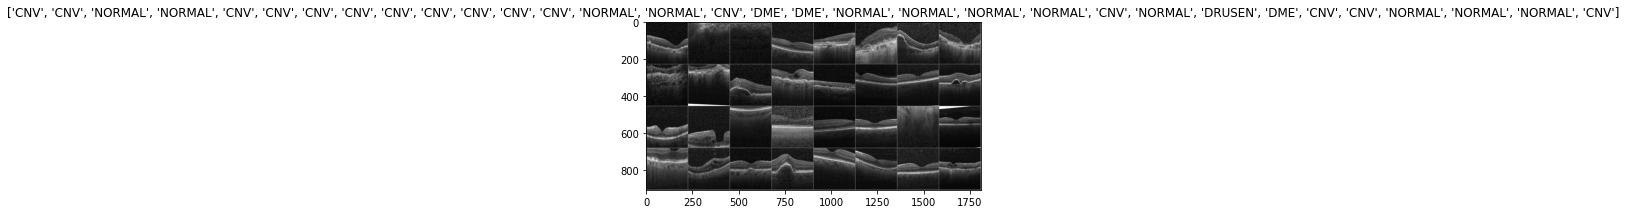

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
for id, data in enumerate(dataloaders['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([32, 1, 224, 224])
torch.Size([32])


In [10]:
inputs = torch.Tensor(32, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([32, 1, 224, 224])


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=60):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_accuracies.append(epoch_acc)

            if phase == 'val':
              val_losses.append(epoch_loss)
              val_accuracies.append(epoch_acc)

            # 1 epoch 마다 loss 출력
            x_train_losses = np.arange(len(train_losses))
            x_val_losses = np.arange(len(val_losses))
            plt.plot(x_train_losses, train_losses)
            plt.plot(x_val_losses, val_losses)            
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss per epoch')
            plt.legend(['train', 'val'])
            plt.show()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies # 5개의 변수를 반환

In [12]:
model_ft = ResNet18()

#os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')
# Present working directory
#!pwd
#PATH = 'ResNet18_retina.pth'->파일명에 따라서 다른이름으로 수정하여저장
# 학습된 모델 파라미터 로드
#model_ft.load_state_dict(torch.load(PATH))

In [13]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/59
----------


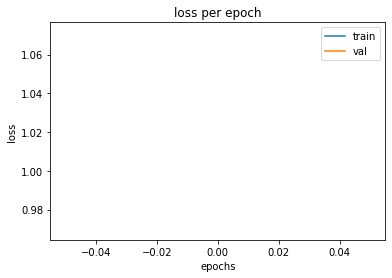

train Loss: 1.0205 Acc: 0.6092


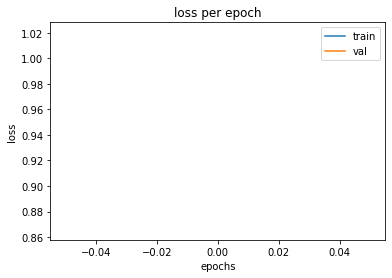

val Loss: 0.8656 Acc: 0.6792

Epoch 1/59
----------


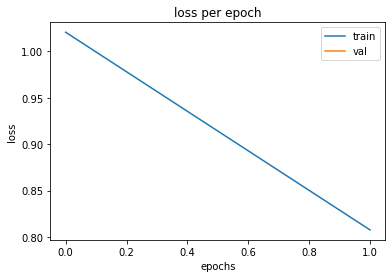

train Loss: 0.8076 Acc: 0.6938


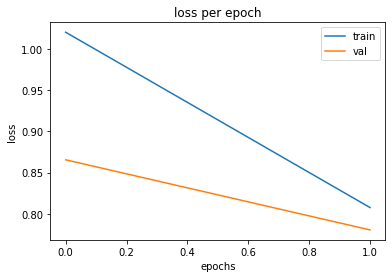

val Loss: 0.7804 Acc: 0.6927

Epoch 2/59
----------


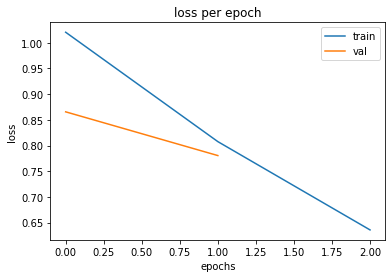

train Loss: 0.6357 Acc: 0.7571


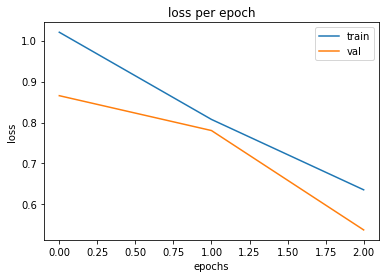

val Loss: 0.5377 Acc: 0.7988

Epoch 3/59
----------


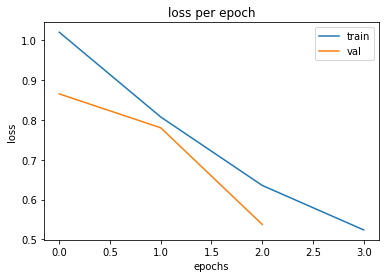

train Loss: 0.5238 Acc: 0.8037


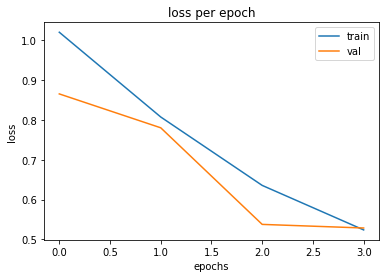

val Loss: 0.5287 Acc: 0.8023

Epoch 4/59
----------


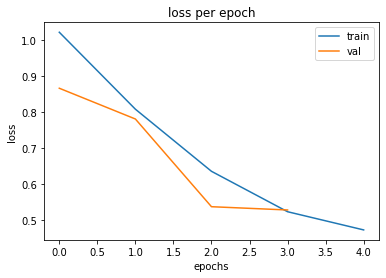

train Loss: 0.4735 Acc: 0.8246


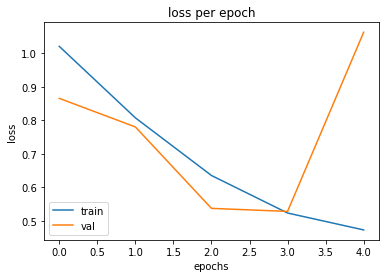

val Loss: 1.0627 Acc: 0.6820

Epoch 5/59
----------


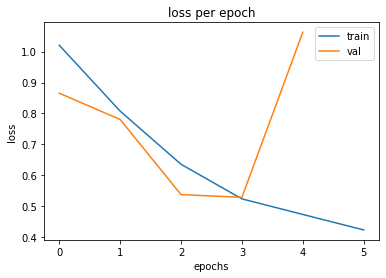

train Loss: 0.4234 Acc: 0.8437


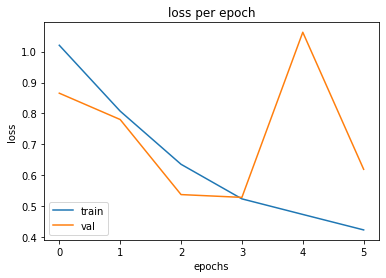

val Loss: 0.6194 Acc: 0.7913

Epoch 6/59
----------


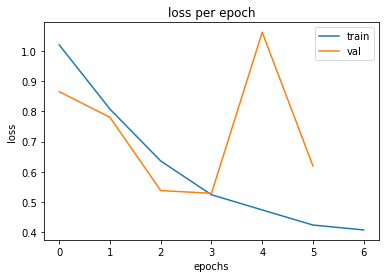

train Loss: 0.4072 Acc: 0.8489


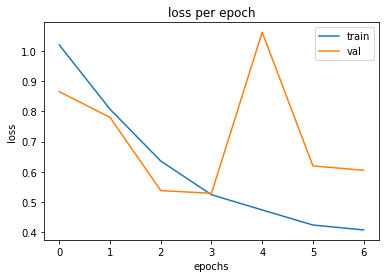

val Loss: 0.6050 Acc: 0.7988

Epoch 7/59
----------


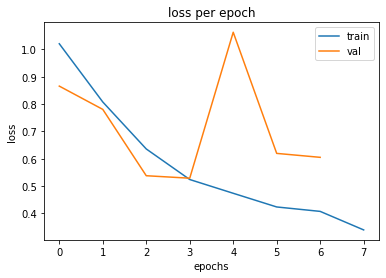

train Loss: 0.3395 Acc: 0.8730


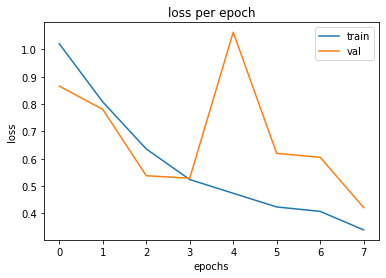

val Loss: 0.4213 Acc: 0.8467

Epoch 8/59
----------


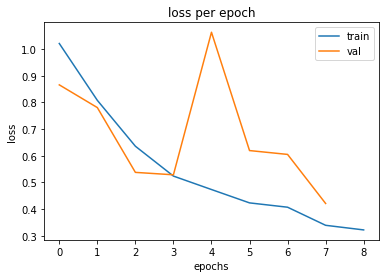

train Loss: 0.3222 Acc: 0.8809


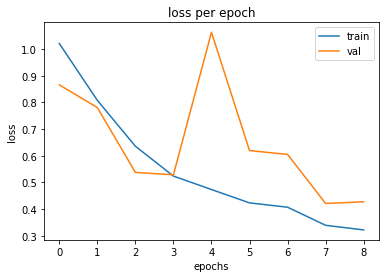

val Loss: 0.4275 Acc: 0.8485

Epoch 9/59
----------


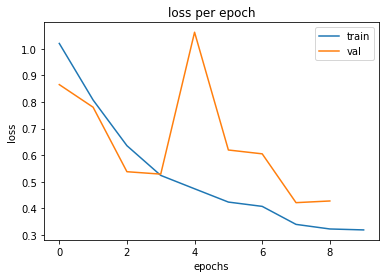

train Loss: 0.3186 Acc: 0.8807


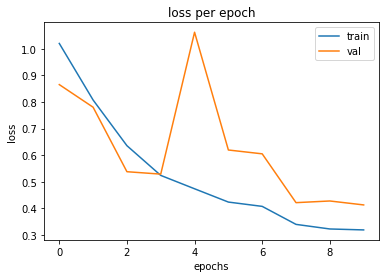

val Loss: 0.4127 Acc: 0.8432

Epoch 10/59
----------


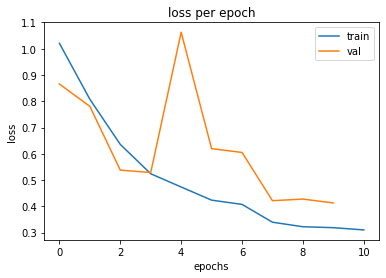

train Loss: 0.3101 Acc: 0.8861


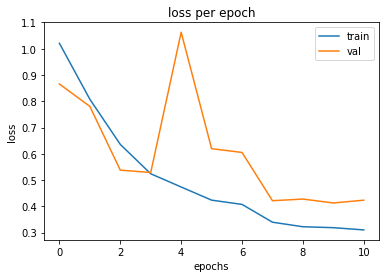

val Loss: 0.4232 Acc: 0.8474

Epoch 11/59
----------


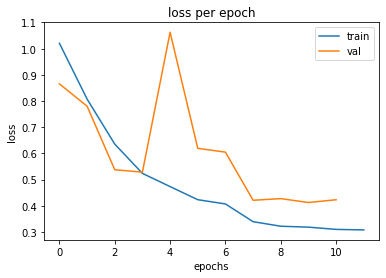

train Loss: 0.3081 Acc: 0.8852


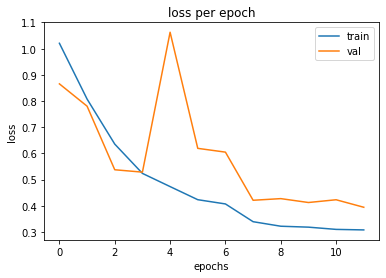

val Loss: 0.3945 Acc: 0.8630

Epoch 12/59
----------


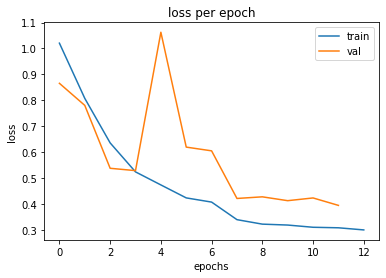

train Loss: 0.2999 Acc: 0.8879


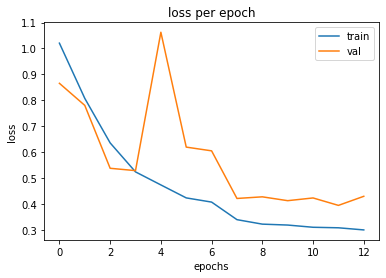

val Loss: 0.4296 Acc: 0.8499

Epoch 13/59
----------


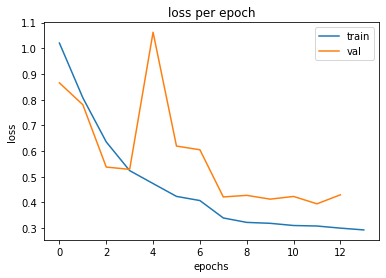

train Loss: 0.2929 Acc: 0.8918


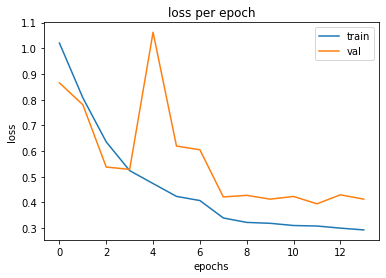

val Loss: 0.4128 Acc: 0.8517

Epoch 14/59
----------


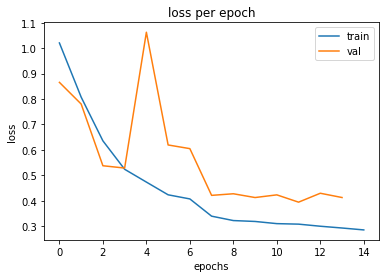

train Loss: 0.2854 Acc: 0.8933


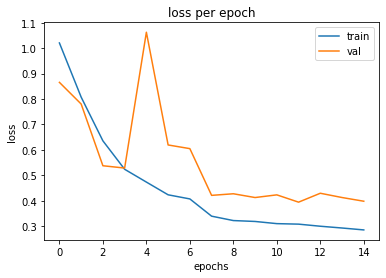

val Loss: 0.3982 Acc: 0.8563

Epoch 15/59
----------


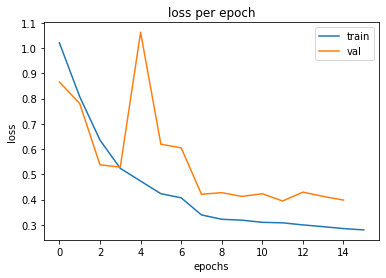

train Loss: 0.2800 Acc: 0.8952


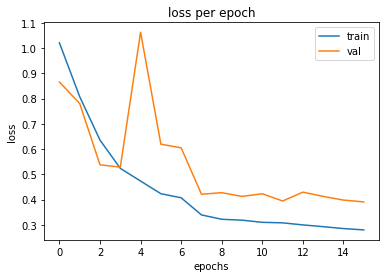

val Loss: 0.3909 Acc: 0.8637

Epoch 16/59
----------


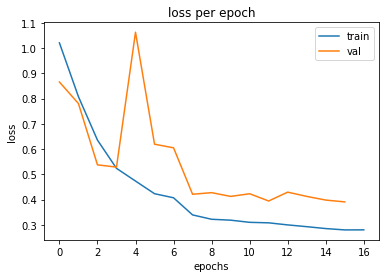

train Loss: 0.2803 Acc: 0.8977


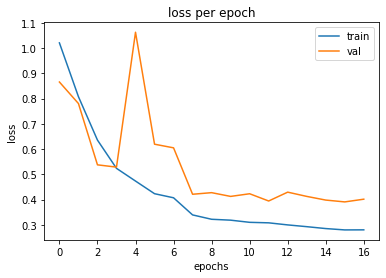

val Loss: 0.4017 Acc: 0.8545

Epoch 17/59
----------


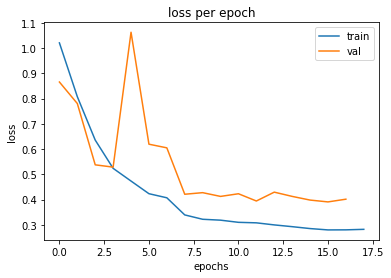

train Loss: 0.2824 Acc: 0.8931


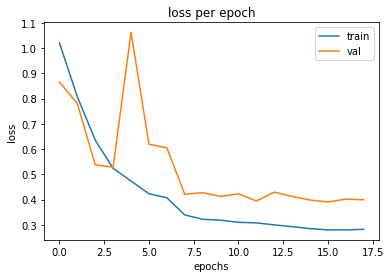

val Loss: 0.3995 Acc: 0.8520

Epoch 18/59
----------


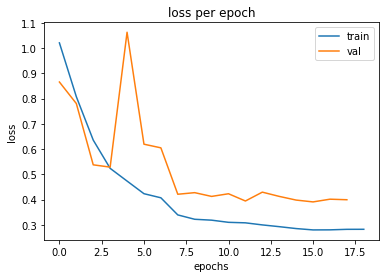

train Loss: 0.2825 Acc: 0.8953


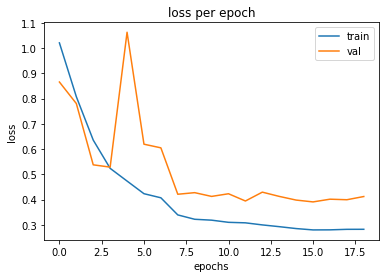

val Loss: 0.4123 Acc: 0.8510

Epoch 19/59
----------


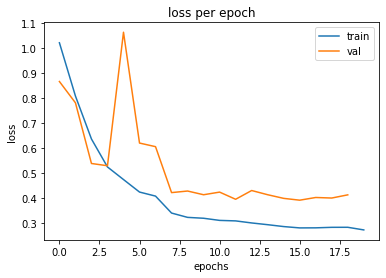

train Loss: 0.2720 Acc: 0.9000


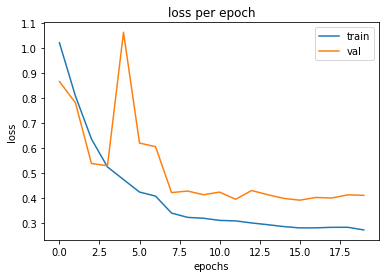

val Loss: 0.4103 Acc: 0.8524

Epoch 20/59
----------


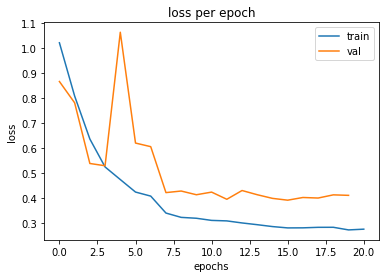

train Loss: 0.2750 Acc: 0.8963


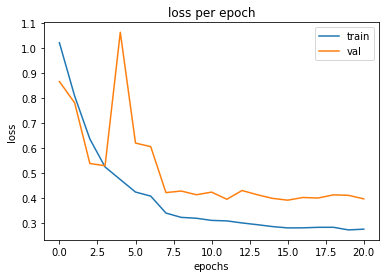

val Loss: 0.3962 Acc: 0.8623

Epoch 21/59
----------


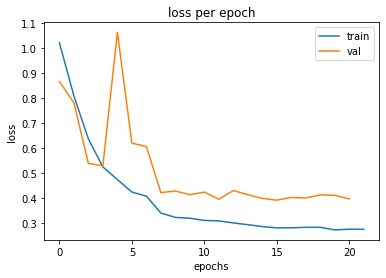

train Loss: 0.2745 Acc: 0.9000


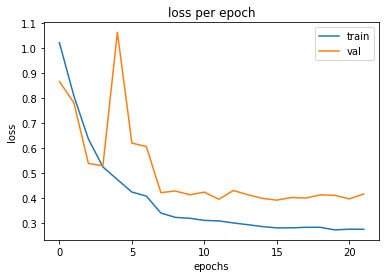

val Loss: 0.4156 Acc: 0.8506

Epoch 22/59
----------


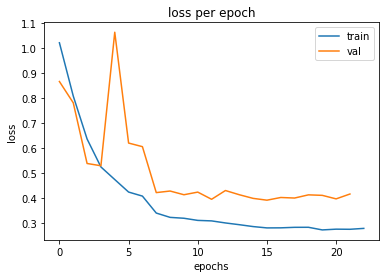

train Loss: 0.2781 Acc: 0.8970


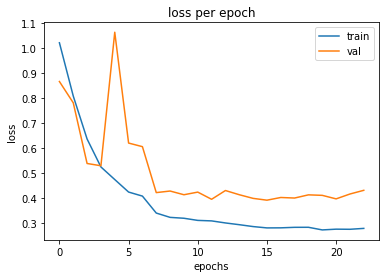

val Loss: 0.4304 Acc: 0.8524

Epoch 23/59
----------


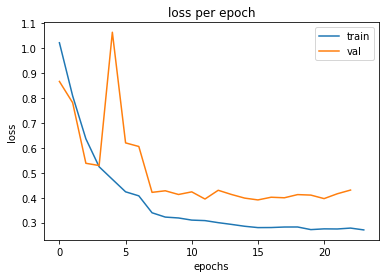

train Loss: 0.2708 Acc: 0.8986


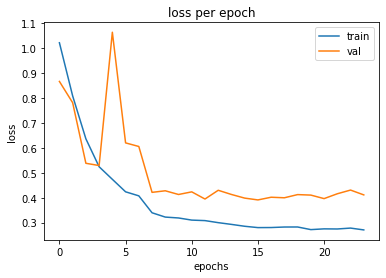

val Loss: 0.4111 Acc: 0.8552

Epoch 24/59
----------


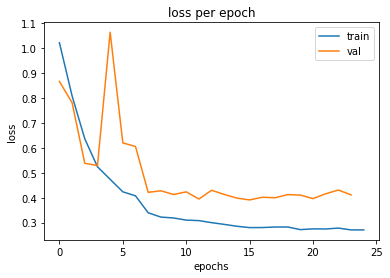

train Loss: 0.2708 Acc: 0.8995


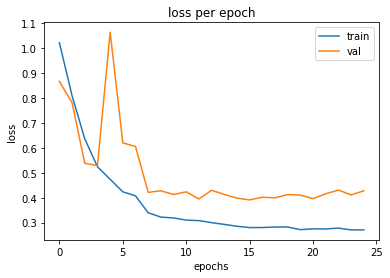

val Loss: 0.4274 Acc: 0.8488

Epoch 25/59
----------


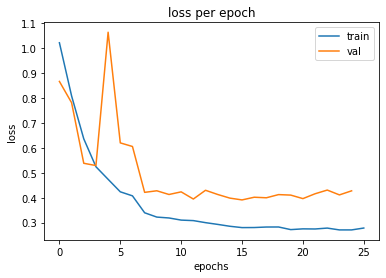

train Loss: 0.2783 Acc: 0.8959


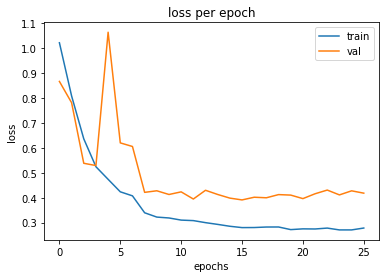

val Loss: 0.4180 Acc: 0.8542

Epoch 26/59
----------


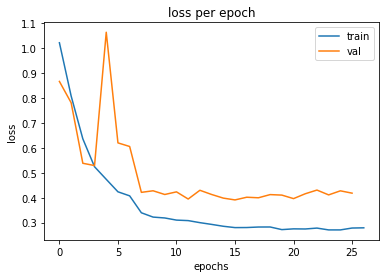

train Loss: 0.2792 Acc: 0.8953


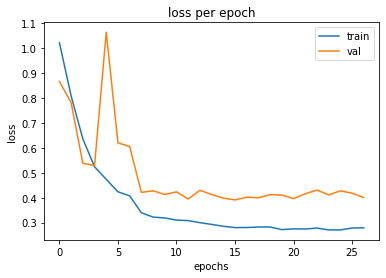

val Loss: 0.4005 Acc: 0.8591

Epoch 27/59
----------


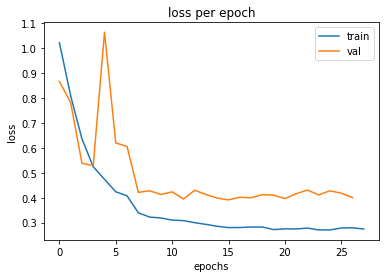

train Loss: 0.2744 Acc: 0.8963


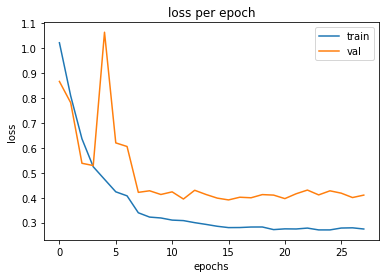

val Loss: 0.4102 Acc: 0.8492

Epoch 28/59
----------


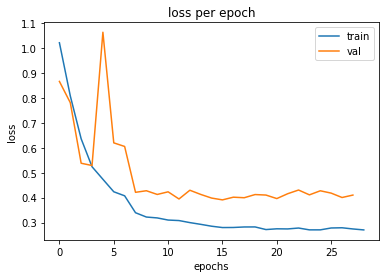

train Loss: 0.2706 Acc: 0.8995


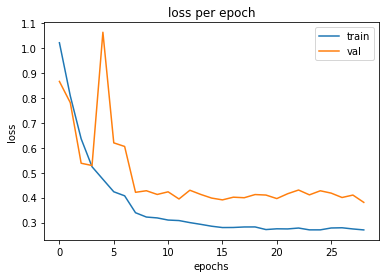

val Loss: 0.3809 Acc: 0.8641

Epoch 29/59
----------


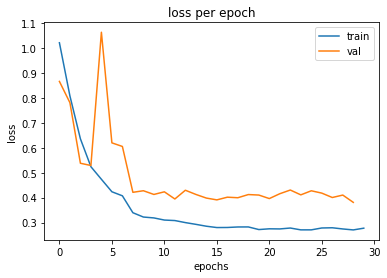

train Loss: 0.2775 Acc: 0.8959


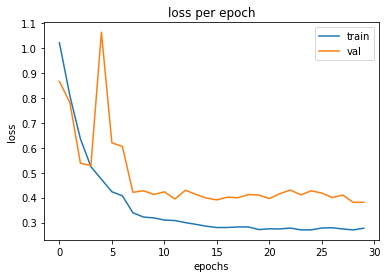

val Loss: 0.3815 Acc: 0.8595

Epoch 30/59
----------


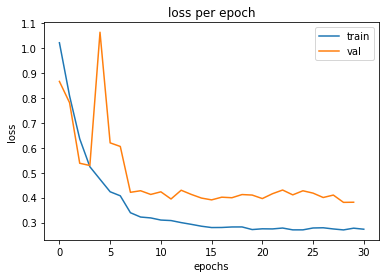

train Loss: 0.2734 Acc: 0.8981


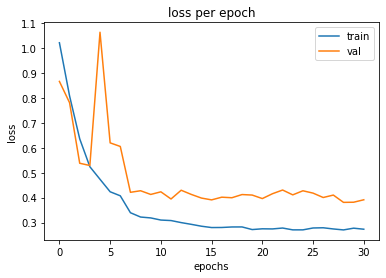

val Loss: 0.3913 Acc: 0.8595

Epoch 31/59
----------


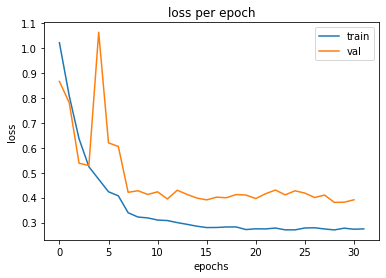

train Loss: 0.2747 Acc: 0.8973


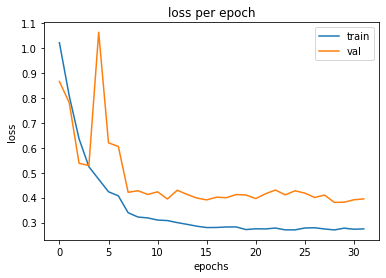

val Loss: 0.3948 Acc: 0.8598

Epoch 32/59
----------


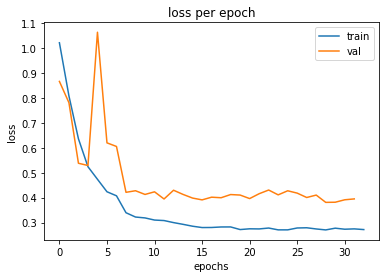

train Loss: 0.2719 Acc: 0.9001


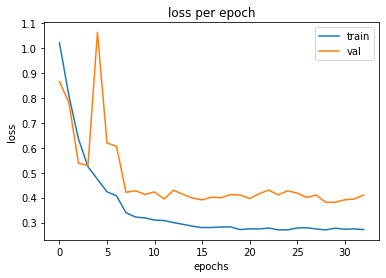

val Loss: 0.4103 Acc: 0.8559

Epoch 33/59
----------


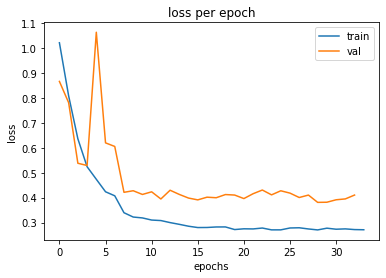

train Loss: 0.2712 Acc: 0.8966


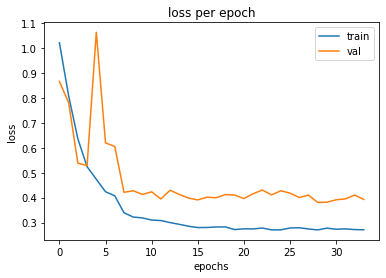

val Loss: 0.3930 Acc: 0.8563

Epoch 34/59
----------


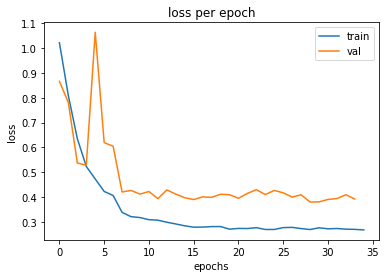

train Loss: 0.2690 Acc: 0.8993


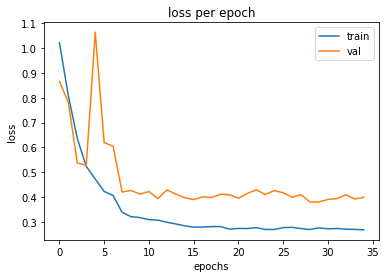

val Loss: 0.3997 Acc: 0.8701

Epoch 35/59
----------


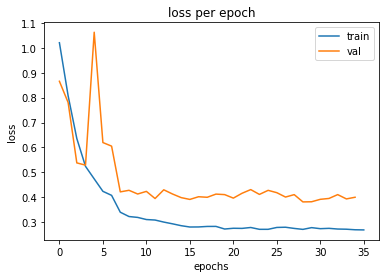

train Loss: 0.2684 Acc: 0.8989


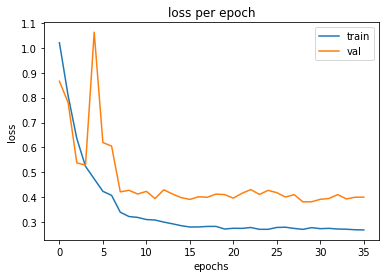

val Loss: 0.4000 Acc: 0.8577

Epoch 36/59
----------


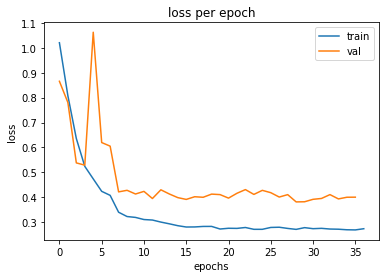

train Loss: 0.2732 Acc: 0.8974


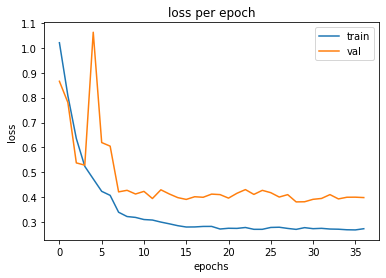

val Loss: 0.3983 Acc: 0.8559

Epoch 37/59
----------


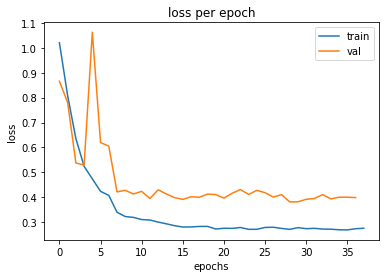

train Loss: 0.2751 Acc: 0.8986


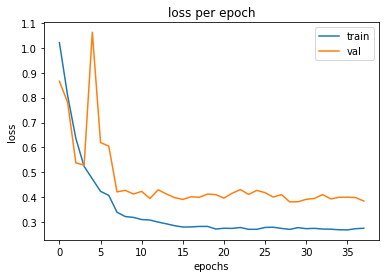

val Loss: 0.3845 Acc: 0.8609

Epoch 38/59
----------


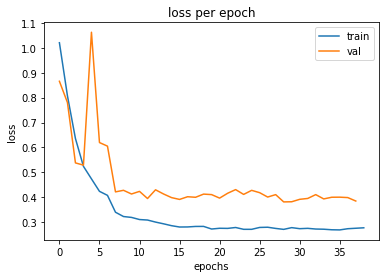

train Loss: 0.2769 Acc: 0.8949


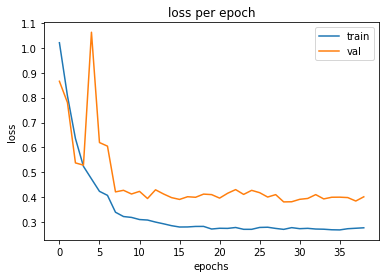

val Loss: 0.4014 Acc: 0.8552

Epoch 39/59
----------


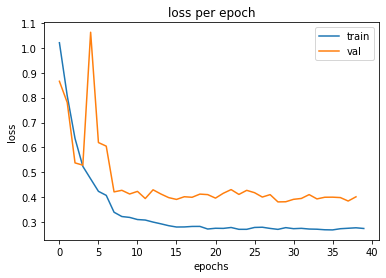

train Loss: 0.2742 Acc: 0.8989


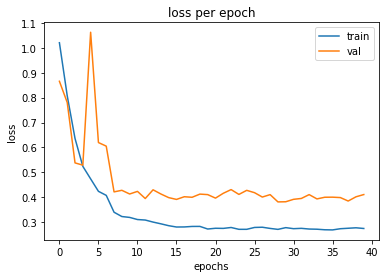

val Loss: 0.4105 Acc: 0.8570

Epoch 40/59
----------


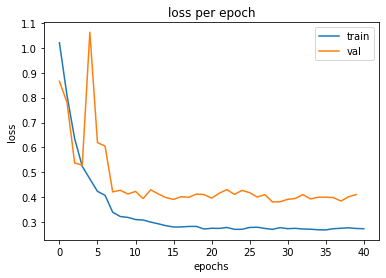

train Loss: 0.2732 Acc: 0.8989


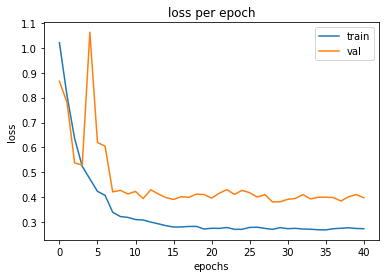

val Loss: 0.3977 Acc: 0.8598

Epoch 41/59
----------


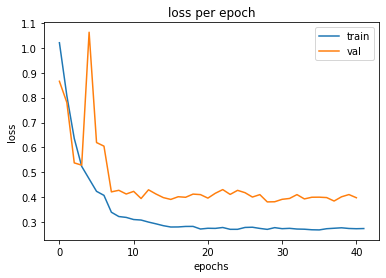

train Loss: 0.2739 Acc: 0.8978


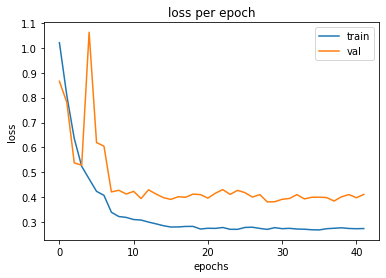

val Loss: 0.4111 Acc: 0.8573

Epoch 42/59
----------


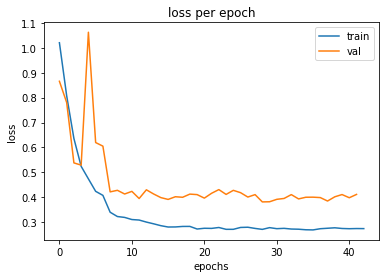

train Loss: 0.2736 Acc: 0.8993


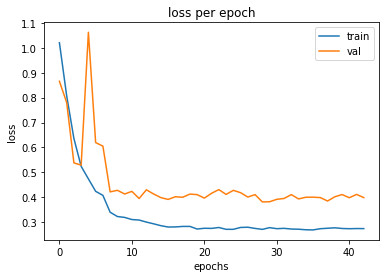

val Loss: 0.3982 Acc: 0.8620

Epoch 43/59
----------


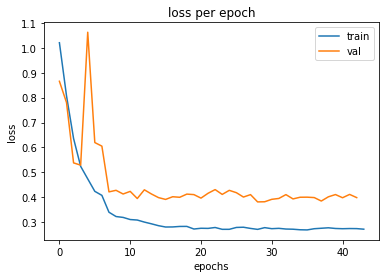

train Loss: 0.2713 Acc: 0.8978


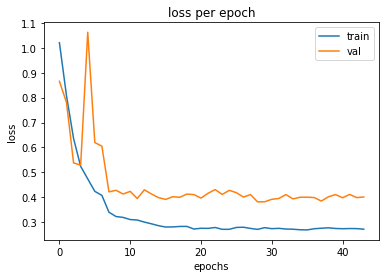

val Loss: 0.4007 Acc: 0.8549

Epoch 44/59
----------


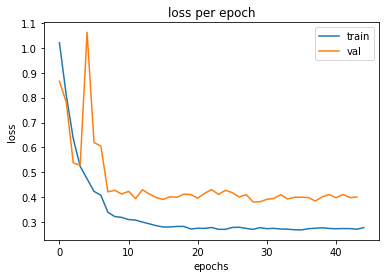

train Loss: 0.2776 Acc: 0.8954


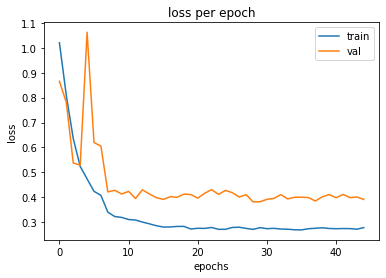

val Loss: 0.3910 Acc: 0.8644

Epoch 45/59
----------


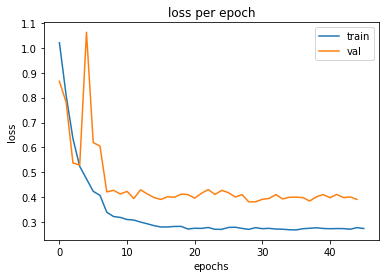

train Loss: 0.2740 Acc: 0.8977


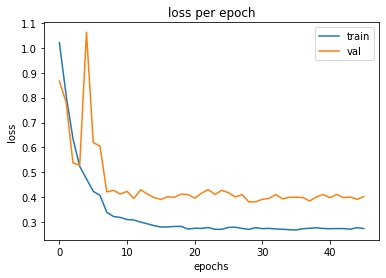

val Loss: 0.4027 Acc: 0.8588

Epoch 46/59
----------


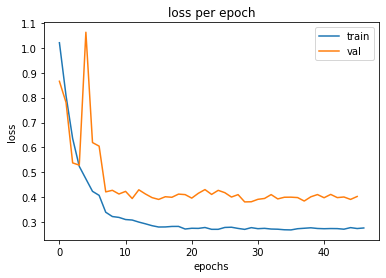

train Loss: 0.2762 Acc: 0.8958


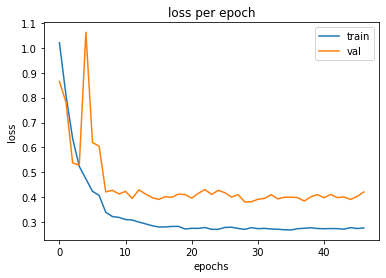

val Loss: 0.4210 Acc: 0.8517

Epoch 47/59
----------


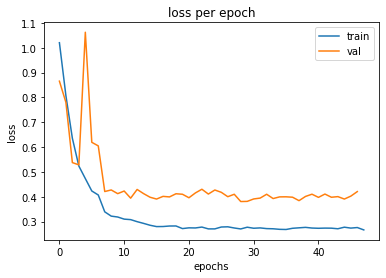

train Loss: 0.2666 Acc: 0.8990


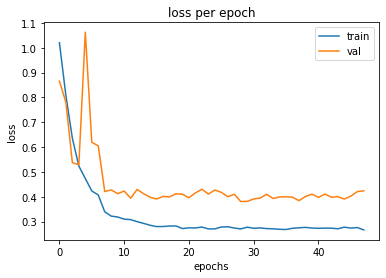

val Loss: 0.4241 Acc: 0.8506

Epoch 48/59
----------


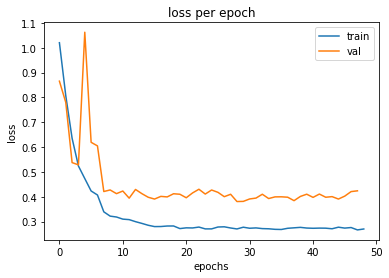

train Loss: 0.2704 Acc: 0.8987


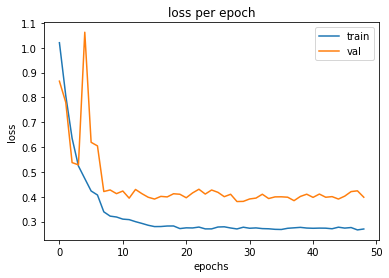

val Loss: 0.3983 Acc: 0.8549

Epoch 49/59
----------


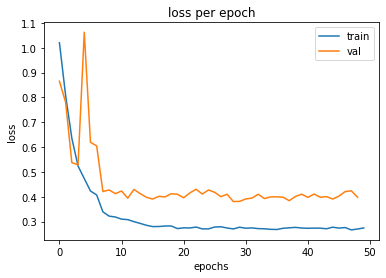

train Loss: 0.2745 Acc: 0.8962


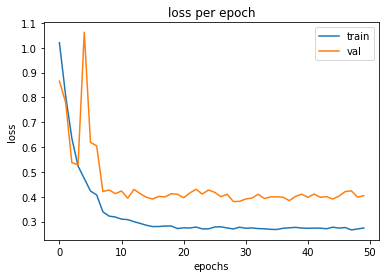

val Loss: 0.4047 Acc: 0.8605

Epoch 50/59
----------


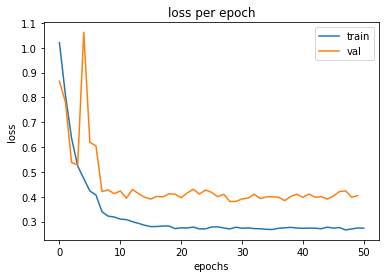

train Loss: 0.2735 Acc: 0.8986


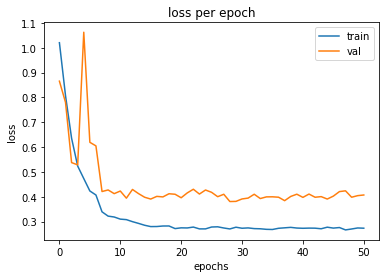

val Loss: 0.4073 Acc: 0.8598

Epoch 51/59
----------


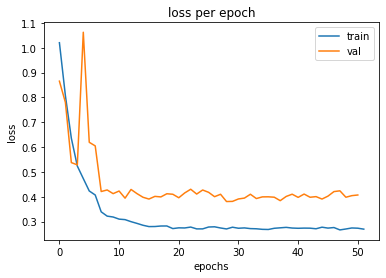

train Loss: 0.2697 Acc: 0.9000


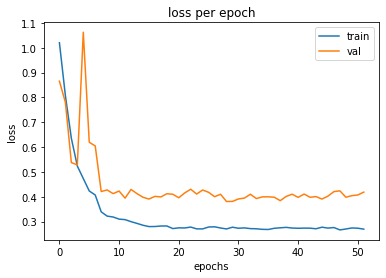

val Loss: 0.4189 Acc: 0.8566

Epoch 52/59
----------


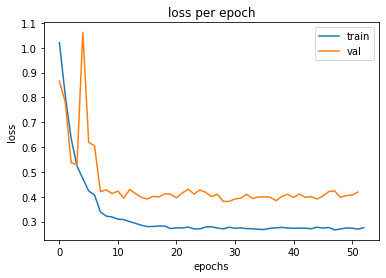

train Loss: 0.2757 Acc: 0.8977


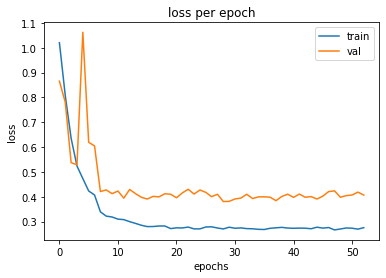

val Loss: 0.4069 Acc: 0.8545

Epoch 53/59
----------


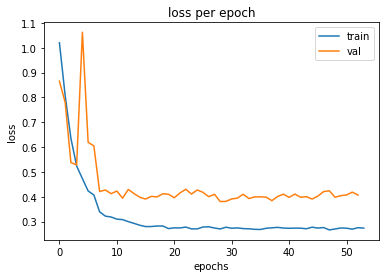

train Loss: 0.2739 Acc: 0.8981


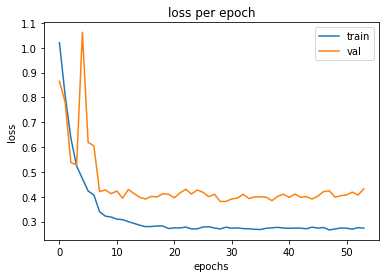

val Loss: 0.4321 Acc: 0.8520

Epoch 54/59
----------


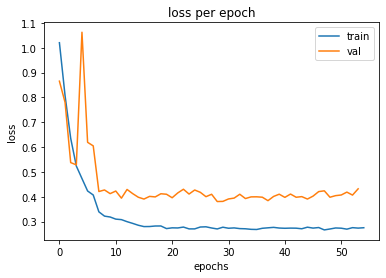

train Loss: 0.2754 Acc: 0.8950


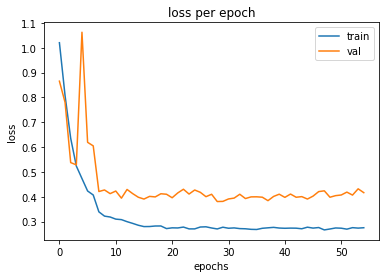

val Loss: 0.4167 Acc: 0.8545

Epoch 55/59
----------


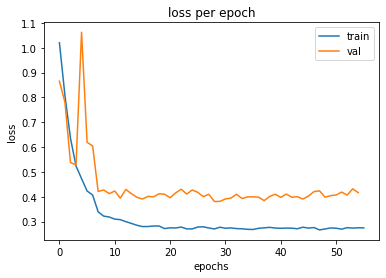

train Loss: 0.2748 Acc: 0.8975


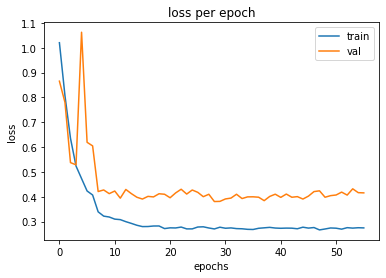

val Loss: 0.4158 Acc: 0.8471

Epoch 56/59
----------


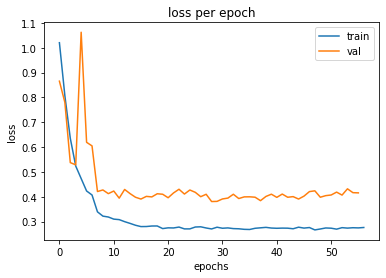

train Loss: 0.2764 Acc: 0.8973


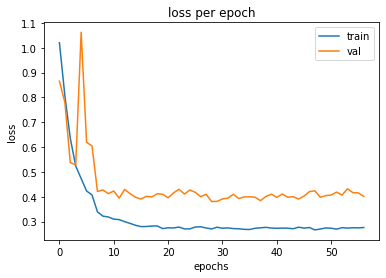

val Loss: 0.4015 Acc: 0.8570

Epoch 57/59
----------


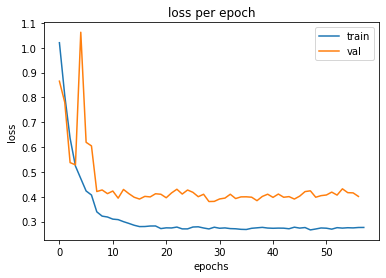

train Loss: 0.2766 Acc: 0.8970


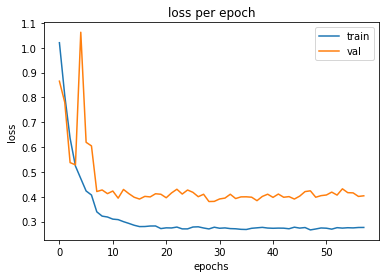

val Loss: 0.4040 Acc: 0.8581

Epoch 58/59
----------


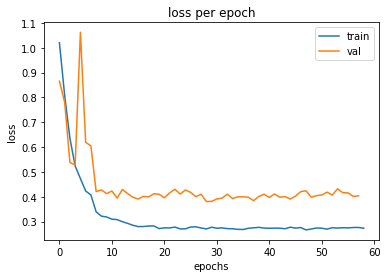

train Loss: 0.2733 Acc: 0.8985


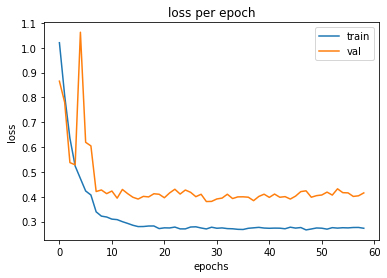

val Loss: 0.4157 Acc: 0.8566

Epoch 59/59
----------


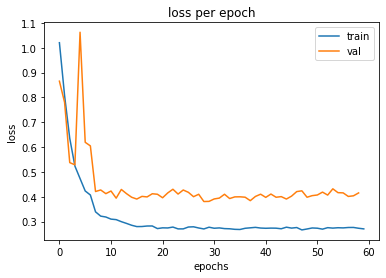

train Loss: 0.2708 Acc: 0.9004


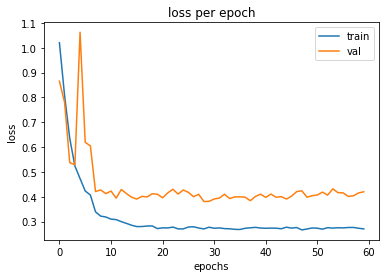

val Loss: 0.4201 Acc: 0.8534

Training complete in 289m 30s
Best val Acc: 0.870121


In [14]:
model_ft, train_losses, train_accuracies, val_losses, val_accuracies  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [15]:
os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')

In [16]:
# Present working directory
!pwd

/content/drive/Shareddrives/ResNet18_Model_parameters


In [17]:
PATH = 'ResNet18_retina_Adam_60epochs_lr=0.01.pth'

In [18]:
torch.save(model_ft.state_dict(), PATH)
print('Model Saved!')

Model Saved!


In [19]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
def test_model(model, num_epochs=1):
    model.eval()
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['test']:
            
            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))


In [22]:
test_model = test_model(net)

Epoch 0/0
----------
test Loss: 1.0550 Acc: 0.7306

Testing complete in 5m 57s
Best Test Acc: 0.000000
